## Activation stats

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export 
from __future__ import annotations
import random, math, torch, numpy as np, matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *

In [ ]:
import torch.nn.functional as F, matplotlib as mpl
from pathlib import Path
from operator import attrgetter, itemgetter
from contextlib import contextmanager

from torch import tensor, nn, optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=160, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

plt.style.use('dark_background')

Let's create a general function to set seed for Pytorch, numpy and random

In [ ]:
#| export
def set_seed(seed, determenistic=False):
    # make torch use deterministic algorithms when available
    torch.use_deterministic_algorithms(determenistic)
    # set seed for torch, random and numpy
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
   

In [ ]:
x, y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

## Baseline

Let's define a usual baseline model to work with.

In [ ]:
def conv(ni, nf, ks=3, act=True):
    # res - conv2d optionally followed by acitvation
    res = nn.Conv2d(ni, nf, ks, stride=2, padding = ks // 2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    # conv layers 8-16-32-64-10. First is with ks=5
    return [conv(1,8, ks=5), conv(8,16),conv(16,32),conv(32,64),conv(64,10, act=False), nn.Flatten()]
     

We want to train quickly, that means training at a high learning rate.

In [ ]:
from torcheval.metrics import MulticlassAccuracy

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
# create callbacks (train, device, metrics, progress)
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [ ]:
def fit(model, epochs=1, xtra_cbs=None):
    # create a Learner with extra callbacks added to cbs, lr=0.6
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs + fc.L(xtra_cbs))
    # fit
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.153,2.301,0,train
0.208,2.125,0,eval


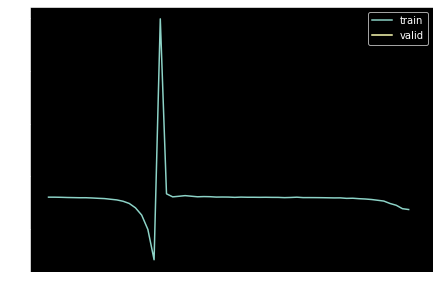

In [ ]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

## Hooks

### Manual insertion 

Hooks are similar to callbacks and are part of Pytorch functionality. There are forward hooks and backward hooks.

In [ ]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        # define layers from layers list
        self.layers = nn.ModuleList(layers)
        # lists to store activation means and std for each layer for each batch
        self.act_means, self.act_stds = [[] for _ in self.layers], [[] for _ in self.layers]
        
    def __call__(self, x):
        # loop through the layers, calculate interim results and append means and std
        for i, l in enumerate(self.layers):
            x = l(x)
            # import ipdb; ipdb.set_trace()
            # append means and stds of each layer to list
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds[i].append(to_cpu(x).std())
           
        return x
    
    # make it an iterator to loop through layers
    def __iter__(self): return iter(self.layers)

accuracy,loss,epoch,train
0.154,2.302,0,train
0.203,2.123,0,eval


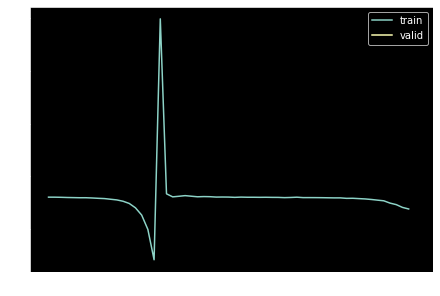

In [ ]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

Plot means and stds for every batch. We see that activations are increasing at an exponential rate and then drop to zero. This is vey bad news for us because it practically means that there is no training at all - inputs to each next layer are zero and outputs are zero. Generally we weant mean to be zero and standard deviation to be 1.

Here after batch 30 means are zero and stds are zero, which means all numbers are bascially the same and zero.

__Maybe add color graph (Karpathy)__

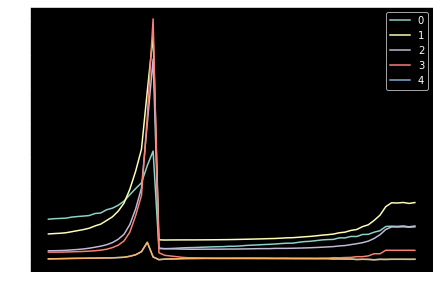

In [ ]:
# plot activation means for each layer
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

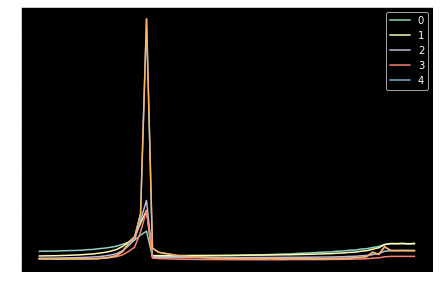

In [ ]:
# plot activation stds for each layer
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

### Pytorch hooks 

Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook). Hooks don't require us to rewrite the model.

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output in the correct position of our list.

In [ ]:
# to keep tracks means and stds for each layer for each batch
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [ ]:
def append_stats(i, # the layer number
                 mod, # the module
                 inp, # input
                 outp # output
                ): 
    act_means[i].append(to_cpu(outp).mean())
    act_stds[i].append(to_cpu(outp).std())

In [ ]:
# we go through each layer of a model, grab its layer and register `append_stats` function with it
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.151,2.299,0,train
0.303,2.137,0,eval


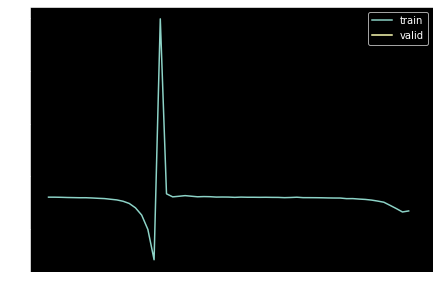

In [ ]:
 fit(model);

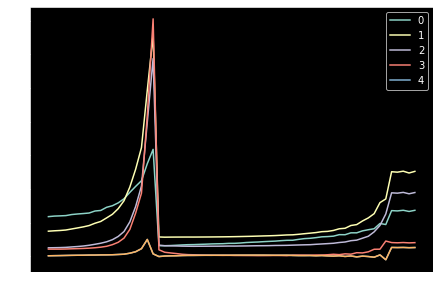

In [ ]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

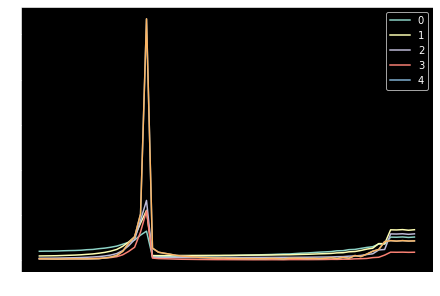

In [ ]:
for o in act_stds: plt.plot(o)
plt.legend(range(5));

## Hoook class 

We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

From Pytroch: `m.register_forward_hook`

The hook will be called every time after `forward` has computed an output.
It should have the following signature:

    hook(module, input, output) -> None or modified output


In [ ]:
_o = model[0].register_forward_hook
_o

<bound method Module.register_forward_hook of Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
)>

In [ ]:
#| export
class Hook:
    def __init__(self, 
                 m, # module that we a hooking
                 f # function
                ):
        # register hook with a function on a layer (module)
        self.hook = m.register_forward_hook(partial(f, self))
    # remove hook
    def remove(self): self.hook.remove()
    # del method
    def __del__(self): self.remove()

In [ ]:
# we need to pass `hook` as additional argument to capture its reference
# and append to its stats attribute
def append_stats(hook, mod, inp, outp):
    # if no stats attribute - create it (tuple of acts_means and acts_stds
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    # put stats to cpu
    acts = to_cpu(outp)
    # append activations mean and std to stats
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

We create a list of hooks, where each hook is for a model layer. During initialization it registers itself as a forward hook for that module and applies `append_stats` (`f`) to it.

In [ ]:
# add hook to each of the model first 5 layers
hooks = [Hook(m, append_stats) for m in model[:5].children()]

In [ ]:
hooks

[<__main__.Hook>,
 <__main__.Hook>,
 <__main__.Hook>,
 <__main__.Hook>,
 <__main__.Hook>]

accuracy,loss,epoch,train
0.161,2.301,0,train
0.347,2.154,0,eval


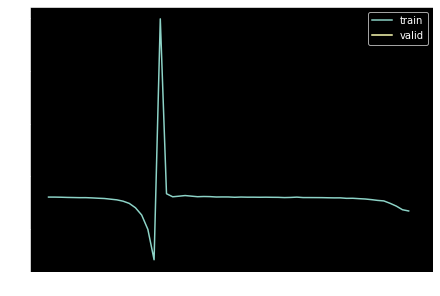

In [ ]:
learn = fit(model)

<matplotlib.legend.Legend>

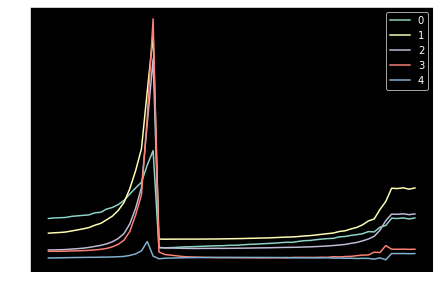

In [ ]:
# for each hook plot mean, remove hook and add legend in the end
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5))

## A Hooks class

Let's go further and create a `Hooks` class. We will use contextmanager for it, so let's remind ourselves about it.

In [ ]:
class DummyCtxMgr:
    def __enter__(self, *args):
        print("let's go")
        return self
    def __exit__(self, *args): print("all done!")
    def hello(self): print("hello.")

First `__enter__` method is run and it returns `self` and puts it into `dcm` variable.

In [ ]:
with DummyCtxMgr() as dcm: dcm.hello()

let's go
hello.
all done!


We can also inherit from python standard library and extend functionaliy of the built-in objects

In [ ]:
class DummyList(list):
    def __delitem__(self, i):
        print(f"Say bye to {self[i]}")
        super().__delitem__(i)

In [ ]:
dml = DummyList([1,2,3])
dml

[1, 2, 3]

In [ ]:
del(dml[1])

Say bye to 2


To create a context manager we create a class with two special methods: `__enter__` and `__exit__`. `__enter__` is run as soon as we hit `with` statement and its result is stored into `as` variable.

In [ ]:
#| export
class Hooks(list):
    # register a Hook for each module using class constructor
    def __init__(self, ms, f):  super().__init__([Hook(m, f) for m in ms])
    # enter context
    def __enter__(self, *args): return self
    # exit context
    def __exit__(self, *args): self.remove()
    # del Hooks
    def __del__(self): 
    # del separate item
        self.remove()
    def __delitem__(self, i):
        # delete item from list
        self[i].remove()
        super().__delitem__(i)
        
        
    # `remove` called by del
    def remove(self): 
        for o in self: o.remove()
       

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.153,2.299,0,train
0.256,2.151,0,eval


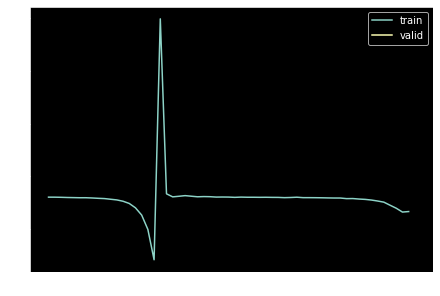

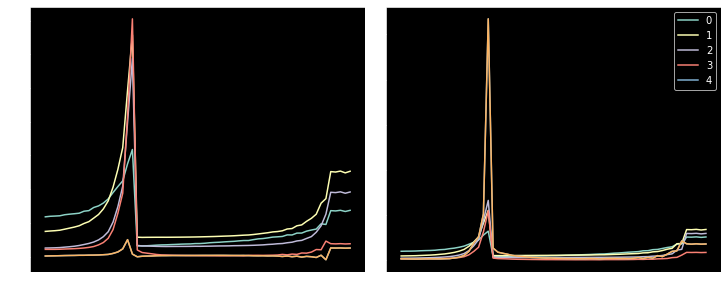

In [ ]:
# fit model in Hooks context
with Hooks(model, append_stats) as hooks:
    fit(model)
    # plot stats for each hook on two plots, use figsize (10, 4)
    fig, axs = plt.subplots(1,2,figsize=(10,4))
    for h in hooks:
        for i in 0,1: axs[i].plot(h.stats[i])
    # add legend
    plt.legend(range(5))

## HooksCallback

Due to some limitations with context manager, let's create HooksCallback

In [ ]:
learn.model.apply(fc.noop)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
#| export
class HooksCallback(Callback):
    def __init__(self, 
                 hookfunc, # hook function
                 mod_filter=fc.noop, # filter modules to hook to
                 on_train=True, # use hooks on train
                 on_valid=False, # use hooks on valid
                 mods=None): # modules to hook to
        fc.store_attr()
        super().__init__()
    
    
    def before_fit(self, learn):
        # if modules are passed - use them
        if self.mods: mods = self.mods
        # if no modules are passed - grab all modules from model and apply filter to it from fastcore
        else: mods = learn.model.apply(self.mod_filter)
        # hook onto modules with a _hookfunc wrapper
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))
        
        
    
    def _hookfunc(self, learn, *args, **kwargs):
        # check that if our hook is applied during training - our model is training and
        # vice versa for validation
        if (self.on_train and learn.training) or (self.on_valid and not learn.training):
            return self.hookfunc(*args, **kwargs)
        

    # remove hooks after fit
    def after_fit(self, learn): self.hooks.remove()
    
    # make calss an iterable
    def __iter__(self): return iter(self.hooks)

    # get length
    def __len__(self): return len(self.hooks)

In [ ]:
fc.filter_ex([1,2,3,4,5], f=lambda x: x%2==0)

[2, 4]

In [ ]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.154,2.301,0,train
0.196,2.126,0,eval


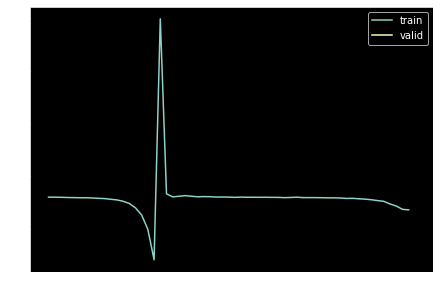

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc]);

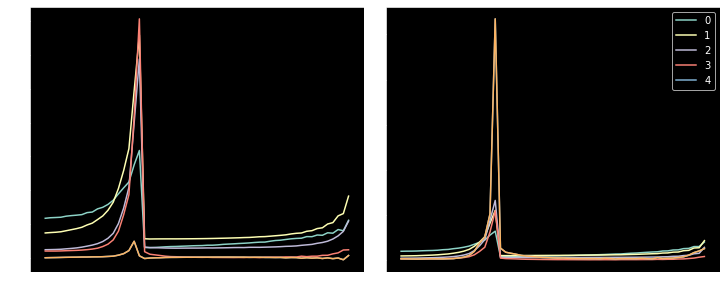

In [ ]:
# get figure and axis and plot stats
fig, axs = plt.subplots(1,2,figsize=(10,4))
for h in hc.hooks:
    for i in (0,1): axs[i].plot(h.stats[i])
plt.legend(range(5));

## Histograms

Histograms are one useful way of looking into our model and its trained weights to check if it makes sense or not. First we will make changes to `append_stats` function so that it also stores hist as on of its stats.

In [ ]:
#| export
def append_stats(hook, mod, inp, outp):
    # if no stats attribute - create it
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    # move outputs to cpu
    acts = to_cpu(outp)
    # add activation means, std and histogram of absolute values (40 bins, min=0 to max=10)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))

accuracy,loss,epoch,train
0.154,2.301,0,train
0.192,2.144,0,eval


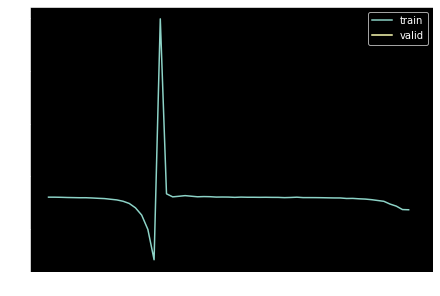

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc]);

In [ ]:
torch.arange(0,100).float().histc(5,0,10)

tensor([2., 2., 2., 2., 3.])

In [ ]:
test_hook = next(iter(hc))
test_hook.stats[2][:5]

[tensor([1344328.,  166094.,   56854.,   33700.,    4465.,     191.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.]),
 tensor([1341138.,  166811.,   56834.,   35448.,    5185.,     216.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.]),
 tensor([1338344.,  169289.,   56456.,   35963.,    5370.,     210.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,    

In [ ]:
torch.stack(test_hook.stats[2][:5])

tensor([[1344328.,  166094.,   56854.,   33700.,    4465.,     191.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.],
        [1341138.,  166811.,   56834.,   35448.,    5185.,     216.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.],
        [1338344.,  169289.,   56456.,   35963.,    5370.,     210.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,      

In [ ]:
get_hist(test_hook)

tensor([[14.11, 14.11, 14.11,  ..., 14.21, 14.21, 13.69],
        [12.02, 12.02, 12.04,  ..., 10.30, 10.22,  9.65],
        [10.95, 10.95, 10.94,  ...,  9.89,  9.84,  9.21],
        ...,
        [ 0.00,  0.00,  0.00,  ...,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  ...,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  ...,  0.00,  0.00,  0.00]])

In [ ]:
torch.stack(test_hook.stats[2][0:2]).t().float().log1p()

In [ ]:
#| export
# Thanks to @ste for initial version of histgram plotting code
# stack stats together in a single tensor, transpose it, cast to float and log1p
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

The colorful dimesnion graphs shows a histogram for each pixel column. It takes a histogram for each batch are unrolls it onto a single coloumn, where y-axis is a histogram bins, x-axis is batches and color represents how many values there are for every bin.

Ideally we would like to see a rectangle with a maximum not changing very much and even (normal) gradient / distribution. Here we see that the majority of values are around zero.

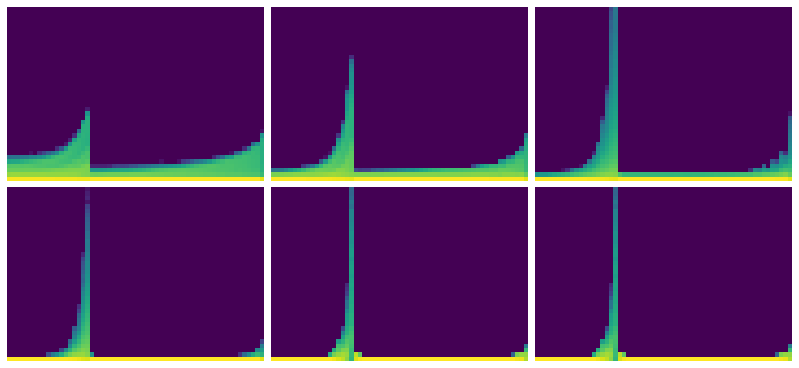

In [ ]:
# get fig and axis
fig,axes = get_grid(len(hc), figsize=(11,5))
# loop through hooks and plot historgams
for ax, h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin='lower')

In [ ]:
#| export
def get_min(h):
    # get transposed tensor as in `get_hist`
    h1 = torch.stack(h.stats[2]).t().float()

    # take ratio of two lowest bins (near zero) and check their ratio to the rest acivations
    # do this for each batch
    return h1[0]/h1.sum(0)

In [ ]:
get_min(test_hook)

tensor([0.84, 0.84, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.82, 0.82, 0.81, 0.81, 0.80, 0.79, 0.78, 0.77, 0.77, 0.75, 0.73, 0.96, 0.96, 0.96, 0.96, 0.95, 0.95,
        0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93,
        0.93, 0.93, 0.93, 0.93, 0.92, 0.93, 0.92, 0.92, 0.92])

In [ ]:
torch.stack(test_hook.stats[2]).t().float().shape

torch.Size([40, 59])

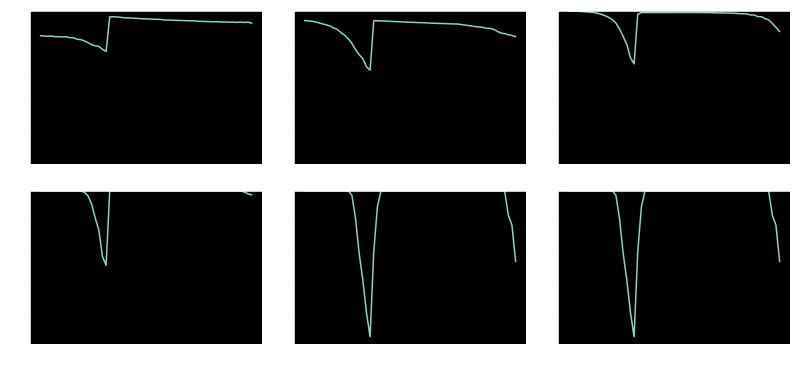

In [ ]:
# get fig & axes and plot (11,5)
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flatten(), hc):
    ax.plot(get_min(h))
    # y_lim
    ax.set_ylim(0,1)

## ActivationStats 

Create a general ActivationsStats subclassing HooksCallback

In [ ]:
#| export
class ActivationStats(HooksCallback):
    # super init
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)
    
    
    def color_dim(self, figsize=(11,5)):
        # grab grid based on length of stats
        fig, axes = get_grid(len(self), figsize=figsize)
        # plot colorful dims plots for each hook
        for ax, h in zip(axes.flat, self.hooks):
            show_image(get_hist(h), ax=ax, origin='lower')
    
    def dead_chart(self, figsize=(11,5)):
        # grab grid based on length of stats
        fig, axes = get_grid(len(self), figsize=figsize)
        # plot dead_chart (min(h)
        for ax, h in zip(axes.flat, self.hooks):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)
    
    
    def plot_stats(self, figsize=(10,4)):
        # create subplots and plot means and std
        fig, axs = plt.subplots(1,2,figsize=figsize)
        for h in self:
            for i in 0,1: axes[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

In [ ]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.159,2.299,0,train
0.262,2.165,0,eval


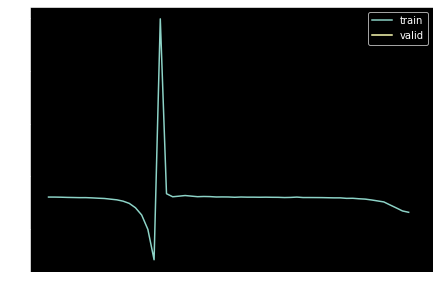

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats]);

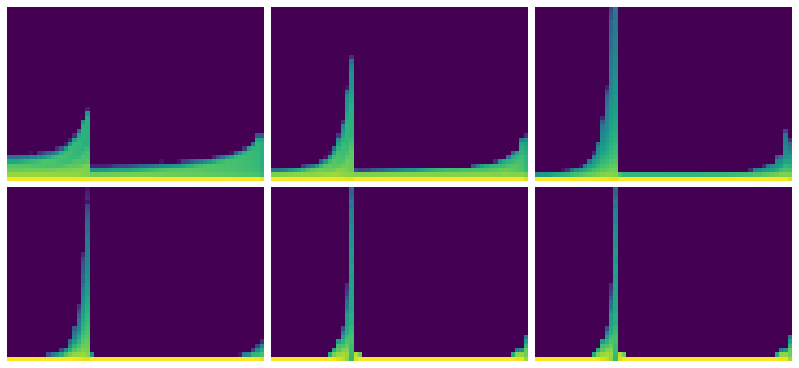

In [ ]:
astats.color_dim()

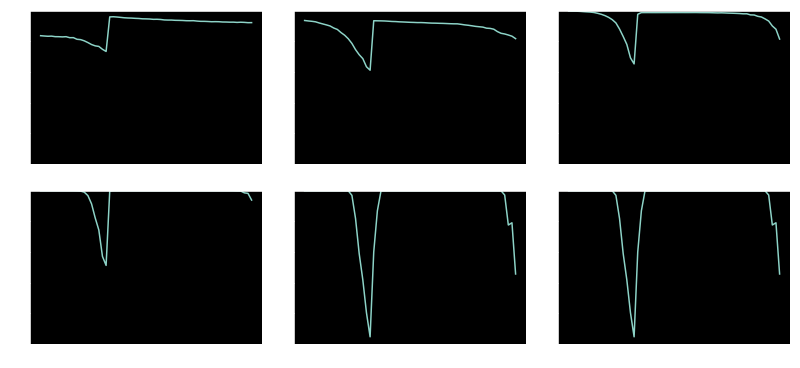

In [ ]:
astats.dead_chart()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

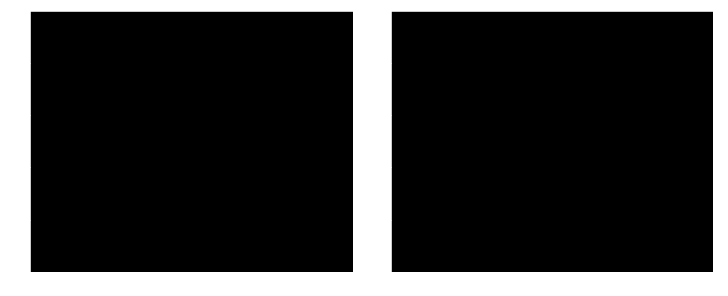

In [ ]:
astats.plot_stats()